## Tutorial 2: Using Scikit-learn on Sentinel-2 Image Data
---

*Authors: [Joe Fennell](https://github.com/joe-fennell/), [Therese Cantwell](https://github.com/TMCantwell/), [Andrés Aguilar Ariza](https://github.com/anaguilarar/) & [Anna Scaife](https://github.com/as595/).*

---

<div class="alert alert-block alert-info">
<b>Objective:</b> You will use the k-means algorithm from the scikit-learn library to perform simple landcover classification on image data from the Sentinel-2 satellite.
</div>

---

Before you start this tutorial, you should make sure that you are familiar with the material in [tutorial 1](https://github.com/darabigdata/AgriHack1/blob/master/TUTORIAL1/OpticalSatelliteImageryTutorial.ipynb).

As before, we're going to use both the [numpy]() and [matplotlib]() libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

and we're also going to import some functions from the [scikit-learn library]():

In [2]:
from sklearn import cluster, preprocessing

---

### Loading the data:

We'll load in the same dataset as before, but we're only going to store a subset of the image this time. We're selecting the pixel range [700:900, 300:500] from the full 1000 x 1000 image, and we'll put that in a numpy array called **im**:

In [3]:
im = np.load('data/S2_London.npy')[700:900,300:500]

---

### Inspecting the data:

To display what those data look like we need to perform the same [image histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) that we did in [tutorial 1](https://github.com/darabigdata/AgriHack1/blob/master/TUTORIAL1/OpticalSatelliteImageryTutorial.ipynb), so let's repeat the function here:

In [4]:
def image_histogram_equalization(image):
    
    """ 
    Function to perform image histogram equalisation.
    
    Method from: 
    http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html
    """
    
    # get histogram of data values using the numpy histogram function:
    image_histogram, bins = np.histogram(image.flatten(), 256, density=True)
    
    # use this to make a cumulative distribution function:
    cdf = image_histogram.cumsum() 
    
    # normalise the CDF:
    cdf = (255-1) * cdf / cdf[-1]

    # use linear interpolation of the CDF to find new pixel values:
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
    if len(image.shape) == 3:
        return image_equalized.reshape(image.shape).astype('uint8')[:,:,::-1]
    else:
        return image_equalized.reshape(image.shape).astype('uint8')
    

and plot up the resulting image:

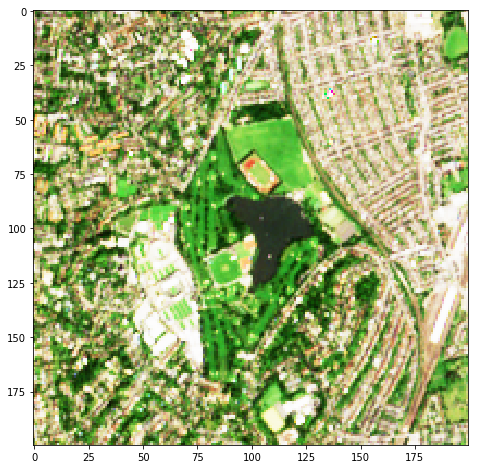

In [5]:
im_equalized = image_histogram_equalization(im[:,:,:3])

plt.figure(figsize=(8,8))
plt.imshow(im_equalized)
plt.show()

In [6]:
print('Image shape = {s[0]} x {s[1]} x {s[2]}'.format(s=im.shape))

Image shape = 200 x 200 x 4


---

### Preparing the data:

We can see that this is an m x n x 4 (4-band) image. To use the scikit-learn functions, the data must be in a 2-dimensional array where each row is a data sample (i.e. a spatial pixel) and each column is a feature value (i.e. channel brightness). 

Four our input image, **im**, there should be 200 x 200 = 4000 samples, each with 4 feature values (columns).

So let's define a function that re-shapes our image into this format:

In [7]:
def multi_to_2d(arr):
    
    """ 
    Function to convert image array into list
    """
    
    s = arr.shape
    
    return np.ravel(arr,(0)).reshape((-1,s[2]))

We can then run this function on the input image, **im**. The output will be called **im_2d**:

In [8]:
im_2d = multi_to_2d(im)

and we can check that the re-shaping has worked by looking at the dimensions of the output array:

In [9]:
print("Shape of new array: ",im_2d.shape)

Shape of new array:  (40000, 4)


---

### Using the data:

Now we have the data in a format suitable for use with scikit-learn we can use the inbuilt [k-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) to try out some simple [unsupervised machine learning](https://en.wikipedia.org/wiki/Unsupervised_learning) on our data.

There are a couple of steps we need to go through:

1. Pre-processing the data: there are different ways of scaling input data, here we are using the [scikit-learn robust_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.robust_scale.html#sklearn.preprocessing.robust_scale) function. There is a comparison of different scaling methods [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

2. Cluster the data: we first need to initiate the [scikit-learn KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) object. We are requesting that it look for 6 clusters - this is smaller than the default value of 8. We then need to use k-means to fit our input data using the <code>fit_predict</code> function, which will compute the cluster centers and predict a cluster index for each data sample (pixel).

In [10]:
# step 1: robust scale the dataset:
im_2d = preprocessing.robust_scale(im_2d)

# step 2(a): construct a KMeans object:
clus = cluster.KMeans(n_clusters=6)

# step 2(b): perform the clustering computation:
clusters = clus.fit_predict(im_2d)

To visualise which pixels belong to each cluster, we can reshape the **clusters** data array to match the shape of the **im** array (only the first two dimensions of im):

In [11]:
clusters = clusters.reshape(im.shape[:-1])

We can then use matplotlib to display the resulting image:

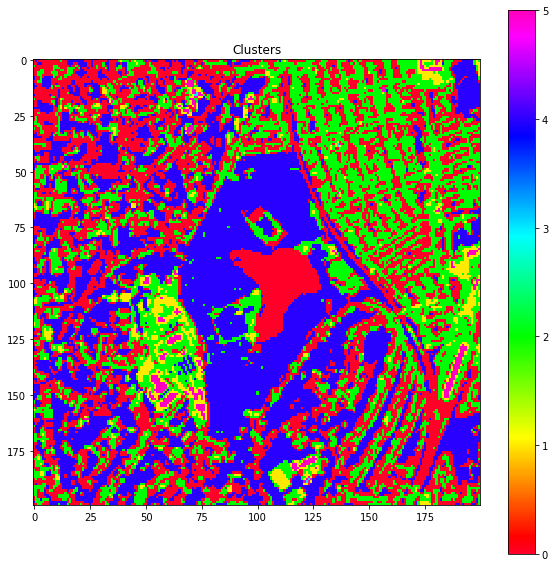

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(clusters,'gist_rainbow')
plt.title('Clusters')
plt.colorbar()
plt.show()

The six clusters are indexed [0, 5], where cluster zero is displayed as red in the image and cluster five is displayed as magenta. The k-means algorithm is suggesting that these six clusters represent *six different types of landcover*, i.e. water, vegetation, buildings etc.

* **Question:** How well do you think it did?
* **Question:** Can you visualise the clusters? [This page](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) might help.

---

That's the end of the tutorial. Now it's your turn!